In [9]:
#Credit: https://github.com/ancatache/LaRoSeDa
#Copyright (C) 2021 - Anca Maria Tache, Mihaela Gaman, Radu Tudor Ionescu
#Removed some of the functions, kepy only Word2Vec training ones


from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from typing import Dict

import torch
import numpy as np
import string
import math
import re
import random
import os

# the seeds were hardcoded in order to maintain consistency between experiments
train_seed = 9001
test_seed = 45
sentences_seed = 97

table = {ord(char): None for char in string.punctuation}

file_dir = os.path.dirname(os.path.realpath('__file__'))

path_pos_reviews = os.path.join(file_dir, 'positive_reviews.json')
path_neg_reviews = os.path.join(file_dir, 'negative_reviews.json')


def cluster_kmeans(n_clusters, data):
    print("Starting the k-means algorithm...")

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(data)

    print("The k-means algorithm has finished.")

    return kmeans



def word2vec_model_from_input(all_sentences, size, epochs):
    print("Starting word2vec...")

    model = Word2Vec(all_sentences, vector_size=size, min_count=1)
    model.train(all_sentences, total_examples=len(all_sentences), epochs=epochs)

    print("word2vec has finished.")
    model.save("w2v_byme300.model")

    return model


def extract_vectors_from_words(vocabulary, model):
    print("Starting replacing words by vectors...")

    data = []
    vocabulary_ordered = []

    for word in vocabulary:
        try:
            word_vector = model.wv.get_vector(word)
            word_vector = np.array(word_vector)
            data.append(np.divide(word_vector, math.sqrt(
                sum(np.power(word_vector, 2)))))  # normalized with norm l2 (w = w ./ sqrt(sum(w.^2)))
            vocabulary_ordered.append(word)
        except KeyError:
            pass
    data = np.array(data)

    print("Finished replacing words by vectors.")

    return data, vocabulary_ordered


def create_histogram_one_voc(words_from_review, n_super_words, clusters_no):
    histogram = np.ones(n_super_words)  # no of outputs
    for i in range(0, len(histogram)):
        histogram[i] = 0

    for word in words_from_review:
        try:
            histogram[clusters_no[word]] += 1
        except:
            pass

    histogram = np.array(histogram)

    return histogram


def write_histo(reviews_dict: Dict[str, Review], key, histogram, file_histo):
    file_histo.write(reviews_dict[key].index + '. ')
    file_histo.write(re.sub('[\[\]]', '', str(histogram)))
    file_histo.write('\n')


def write_labels(reviews_dict: Dict[str, Review], key, file_labels):
    if reviews_dict[key].star_rating == '1' or reviews_dict[key].star_rating == '2':
        file_labels.write(reviews_dict[key].index + '. -1\n')
    if reviews_dict[key].star_rating == '4' or reviews_dict[key].star_rating == '5':
        file_labels.write(reviews_dict[key].index + '. +1\n')


def concatenate_dicts(array_of_dicts):
    super_dict = {}
    for dictionary in array_of_dicts:
        for index, (key, value) in enumerate(dictionary.items()):
            super_dict[key] = value

    return super_dict


def shuffle_dict(dictionary, s):
    shuffled_dict = {}
    keys = list(dictionary.keys())

    random.seed(s)
    random.shuffle(keys)

    for key in keys:
        shuffled_dict[key] = dictionary[key]
    return shuffled_dict


def shuffle_all_sentences(all_sentences, s):
    all_sentences_no_empty = []
    for sentence in all_sentences:
        if len(sentence) > 0:
            all_sentences_no_empty.append(sentence)

    random.seed(s)
    random.shuffle(all_sentences_no_empty)
    return all_sentences_no_empty


def load_reviews(train_samples_number):
    all_sentences_pos = []  # for word2vec
    all_sentences_neg = []  # for word2vec
    reviews_words_pos_train = {}
    reviews_words_neg_train = {}
    reviews_words_pos_test = {}
    reviews_words_neg_test = {}
    reviews: Dict[str, Review] = {}

    try:
        positive_reviews_train, positive_reviews_test = load_reviews_from_path(
            path=path_pos_reviews,
            train_samples_number=train_samples_number)
        negative_reviews_train, negative_reviews_test = load_reviews_from_path(
            path=path_neg_reviews,
            train_samples_number=train_samples_number)

        reviews_words_pos_train, reviews, all_sentences_pos = preprocess_content(
            positive_reviews_train,
            all_sentences_pos,
            reviews_words_pos_train,
            reviews)

        reviews_words_neg_train, reviews, all_sentences_neg = preprocess_content(
            negative_reviews_train,
            all_sentences_neg,
            reviews_words_neg_train,
            reviews)

        reviews_words_pos_test, reviews, all_sentences_pos = preprocess_content(
            positive_reviews_test,
            all_sentences_pos,
            reviews_words_pos_test,
            reviews)

        reviews_words_neg_test, reviews, all_sentences_neg = preprocess_content(
            negative_reviews_test,
            all_sentences_neg,
            reviews_words_neg_test,
            reviews)

        return reviews_words_pos_train, \
               reviews_words_neg_train, \
               reviews_words_pos_test, \
               reviews_words_neg_test, \
               reviews, \
               all_sentences_pos, \
               all_sentences_neg

    except Exception as e:
        print(e)


def preprocess_content(reviews_raw: Dict[str, Review], all_sentences, reviews_words, reviews):
    for review in reviews_raw.values():
        content = (review.content.strip()).lower()
        words_from_review = []
        raw_sentences = content.split('.')
        for sentence in raw_sentences:
            sentence = sentence.translate(table)
            words = sentence.split()
            words_from_review += words
            all_sentences.append(words)
        reviews_words[review.title + review.index] = words_from_review
        reviews[review.title + review.index] = review

    return reviews_words, reviews, all_sentences


def compute_word_to_vec(all_sentences, size_word2vec, epochs_word2vec):
    model = word2vec_model_from_input(all_sentences=all_sentences, size=size_word2vec, epochs=epochs_word2vec)
    model.save("w2v_byme_idk_300.model")
    vocabulary = model.wv.vocab.keys()
    data, vocabulary_ordered = extract_vectors_from_words(vocabulary=vocabulary, model=model)

    return data, vocabulary_ordered


def training(cluster_method, n_clusters, data, vocabulary_ordered, size_vec, epochs_sofm=200):
    clusters = {}

    if cluster_method is "kmeans":
        clusters_no = cluster_kmeans(n_clusters=n_clusters, data=data)
    elif cluster_method is "sofm":
        sofm = cluster_sofm(n_inputs=size_vec, n_outputs=n_clusters, epochs=epochs_sofm, data=data)
        clusters_no = sofm.predict(data).argmax(axis=1)

    # for every word map the cluster number
    for index in range(0, len(vocabulary_ordered)):
        clusters[vocabulary_ordered[index]] = clusters_no[index]

    return clusters

# source: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
def compute_vectors_bert(sentence, model, tokenizer):
    try:
        marked_sentence = "[CLS] " + sentence + " [SEP]"
        tokenized_sentence = tokenizer.tokenize(marked_sentence)

        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sentence)
        segments_ids = [1] * len(tokenized_sentence)

        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():

            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1, 0, 2)

        token_vecs_sum = []

        words = {}
        for i, token in enumerate(token_embeddings):

            sum_vec = torch.sum(token[-4:], dim=0)
            if tokenized_sentence[i] != '[CLS]' and tokenized_sentence[i] != '[SEP]':
                words[tokenized_sentence[i]] = sum_vec.numpy()

            token_vecs_sum.append(sum_vec)

        return words

    except ValueError as e:
        print(e)


def load_reviews_for_bert(data, model, tokenizer, train_samples_number):
    reviews_words_pos_train = {}
    reviews_words_pos_test = {}
    reviews_words_neg_train = {}
    reviews_words_neg_test = {}
    reviews: Dict[str, Review] = {}
    word_vectors_all = [data]

    try:

        positive_reviews_train, positive_reviews_test = load_reviews_from_path(
            path=path_pos_reviews,
            train_samples_number=train_samples_number)
        negative_reviews_train, negative_reviews_test = load_reviews_from_path(
            path=path_neg_reviews,
            train_samples_number=train_samples_number)

        reviews_words_pos_train, reviews, word_vectors_all = preprocess_content_bert(
            positive_reviews_train,
            word_vectors_all,
            reviews_words_pos_train,
            reviews,
            model,
            tokenizer)

        reviews_words_pos_test, reviews, word_vectors_all = preprocess_content_bert(
            positive_reviews_test,
            word_vectors_all,
            reviews_words_pos_test,
            reviews,
            model,
            tokenizer)

        reviews_words_neg_train, reviews, word_vectors_all = preprocess_content_bert(
            negative_reviews_train,
            word_vectors_all,
            reviews_words_neg_train,
            reviews,
            model,
            tokenizer)

        reviews_words_neg_test, reviews, word_vectors_all = preprocess_content_bert(
            negative_reviews_test,
            word_vectors_all,
            reviews_words_neg_test,
            reviews,
            model,
            tokenizer)

        data = concatenate_dicts(word_vectors_all)

    except ValueError as e:
        print(e)

    return reviews_words_pos_train, reviews_words_neg_train, reviews_words_pos_test, reviews_words_neg_test, \
           reviews, data


def preprocess_content_bert(reviews_raw: Dict[str, Review],
                            word_vectors_all,
                            reviews_words,
                            reviews,
                            model,
                            tokenizer):
    for review in reviews_raw.values():
        word_vectors = []
        content = review.content.strip()
        raw_sentences = content.split('.')
        for sentence in raw_sentences:
            sentence = sentence.translate(table)
            vectors = compute_vectors_bert(sentence, model, tokenizer)
            word_vectors.append(vectors)
            word_vectors_all.append(vectors)

        reviews_words[review.title + review.index] = concatenate_dicts(word_vectors).keys()
        reviews[review.title + review.index] = review

    return reviews_words, reviews, word_vectors_all


def transform_data(data):
    data_transformed = []
    vocabulary_ordered = []
    for index, (word, vector) in enumerate(data.items()):
        data_transformed.append(np.divide(vector, math.sqrt(
            sum(np.power(vector, 2)))))  # normalized with norm l2 (w = w ./ sqrt(sum(w.^2)))
        vocabulary_ordered.append(word)
    data_transformed = np.array(data_transformed)
    return data_transformed, vocabulary_ordered


<>:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12016\902735639.py:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cluster_method is "kmeans":
C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12016\902735639.py:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif cluster_method is "sofm":


In [10]:
doc_index = 1 # this will be appended to the name of the output file
no_of_clusters = 500
size_word2vec = 300
epochs_sofm = 200
epochs_word2vec = 200
train_samples_number = 6000
test_samples_number = 1500

reviews_words_pos_train, reviews_words_neg_train, reviews_words_pos_test, reviews_words_neg_test, reviews, \
    all_sentences_pos, all_sentences_neg = load_reviews(train_samples_number)

reviews_words_train = concatenate_dicts([reviews_words_pos_train, reviews_words_neg_train])
shuffled_reviews_train = shuffle_dict(reviews_words_train, train_seed)

reviews_words_test = concatenate_dicts([reviews_words_pos_test, reviews_words_neg_test])
shuffled_reviews_test = shuffle_dict(reviews_words_test, test_seed)

reviews_words = concatenate_dicts([shuffled_reviews_train, shuffled_reviews_test])

all_sentences = all_sentences_pos + all_sentences_neg
all_sentences_shuffled = shuffle_all_sentences(all_sentences, sentences_seed)

data, vocabulary_ordered = compute_word_to_vec(all_sentences=all_sentences_shuffled,
                                               size_word2vec=size_word2vec,
                                               epochs_word2vec=epochs_word2vec)

Starting word2vec...
word2vec has finished.


C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12016\902735639.py:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cluster_method is "kmeans":
C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12016\902735639.py:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif cluster_method is "sofm":
C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12016\902735639.py:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cluster_method is "kmeans":
C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12016\902735639.py:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif cluster_method is "sofm":


AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

C:\Users\Darkinblade\AppData\Local\Temp\ipykernel_12488\501304203.py:24: RuntimeWarning: divide by zero encountered in log
  y = np.log(x)


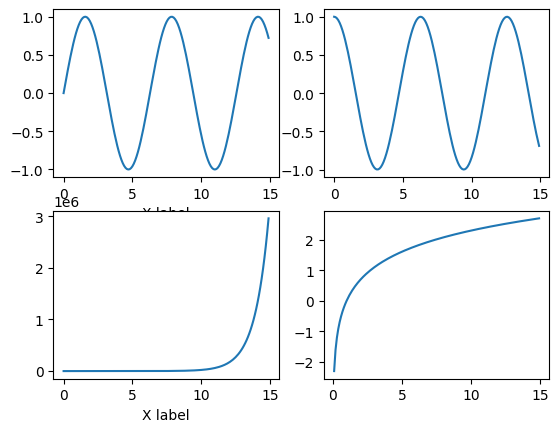

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a subplot grid with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2)

# Create the first plot in the first row and set the x-label
x = np.arange(0, 15, 0.1)
y = np.sin(x)
axes[0, 0].plot(x, y)
axes[0, 0].set_xlabel('X label')

# Create the second plot in the first row without an x-label
y = np.cos(x)
axes[0, 1].plot(x, y)
axes[0, 1].set_xlabel('')

# Create the third plot in the second row and set the x-label
y = np.exp(x)
axes[1, 0].plot(x, y)
axes[1, 0].set_xlabel('X label')

# Create the fourth plot in the second row without an x-label
y = np.log(x)
axes[1, 1].plot(x, y)
axes[1, 1].set_xlabel('')

# Show the plot
plt.show()
